# Classic MCMC

# Problem
- Distributions encountered in real-life are often too complex to directly perform Monte Carlo-based estimations
- Consider random variable $X$ with PDF $f_X$
- The expectation of a function $\phi$ under the law of $X$ is given by
$$ \mathbb{E}_X[\phi] =\int \phi(\xi)f_X(\xi) \, \mathrm{d} \xi$$
- However, the estimator $$\mathbb{E}_X[f] \simeq \frac{1}{N} \sum_{n=1}^{N} \phi(x_n)$$
cannot be easily used anymore, when $f_X$ is too complicated, i.e. .
- Curse of dimensionality:
    - Traditional MC not scaling to high-dimensional problem settings
    - Amount of necessary samples for proper approximations explodes

# Goal
- Nevertheless, draw samples that adhere to $X$
- Assumption:
    - We know $f_X$ up to a multiplicative constant $c\neq 0$: $$f_X = \frac{1}{c} \tilde{f}_X$$
    - We can easily evaluate the energy $\tilde{f}_X$

# Markov Chain Monte Carlo

- Idea: Utilize divide-and-conquer strategy, by iteratively sampling from simpler sub-distributions and remembering the current state
- Thus, a sampling trajectory corresponds to generating a Markov chain
- This yields so-called _Markov Chain Monte Carlo_ techniques
- MCMC algorithms rely heavily on Markov chain theory

# Markov Chains

- Markov Chains are stochastic processes: $$ (X_t)_{t \in \mathbb{T}}.$$
- All $X_t$ live on the same probability space $(\Omega, \mathcal{A}, P)$
- We consider a family of random variables indexed by a time parameter $t$
- The state space $\Omega$ can be either continuous or discrete
- In this session, we are interested in processes with discrete, i.e. at most countable, index sets $\mathbb{T}=\{0, 1,  \dots\}$.
- We refer to discrete-time stochastic processes, which have the so-called  Markov property as _Markov chains_


# Markov Property
![asdf](imgs/0000-non-markov.png)
![test](imgs/0001-markov.png)

The future depends only on the current state...

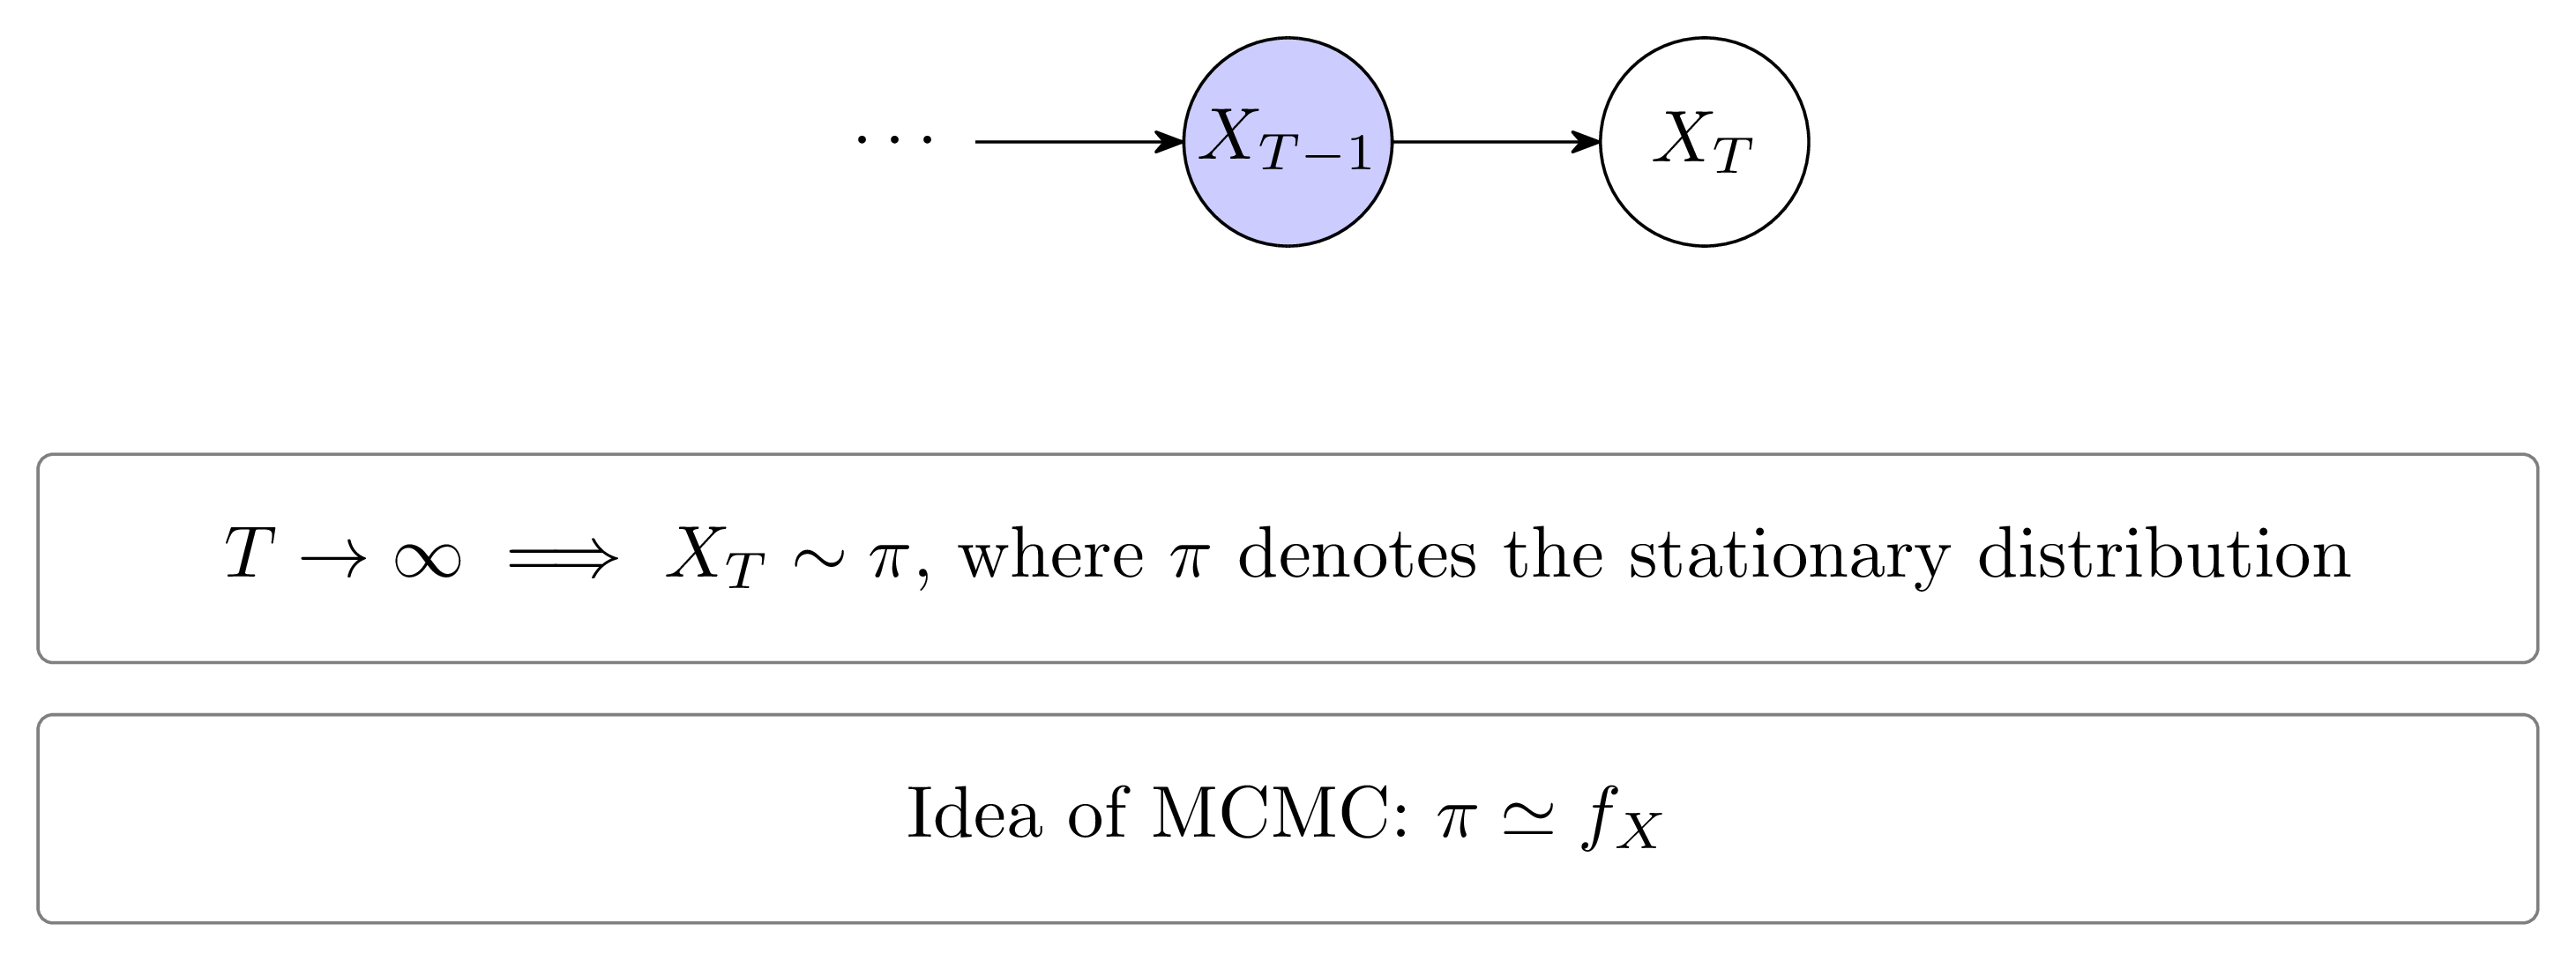![test](imgs/0002-stationary.png)

## Markov Chains

* Used to model relations and dependencies in sequential data
* Model stochastic processes
* Examples: Weather forecasting, language models, gene expression
* Makrov assumption of $n$-th order: Necessary to obtain tractable models
* Mathematically...
$$
p(X_1, X_2, \dots, X_T) = p(X_1) p(X_2 | X_1) \cdots p(X_{T} | X_{T-1})
$$
* $X_1$ is model with a prior probability
* The transition from state $X_{t-1}$ to $X_{t}$ is characterized via the transition distribution/kernel $p(X_{t} | X_{t-1}, \dots, X_{t-n})$
* Typically, $n=1$.

![0004-stationary.png](imgs/0004-graph.png)

# Markov Chain Monte Carlo

* Original idea introduced by Metropolis and Ulam in 1949
* Metropolis algorithm introduced in 1953
* Metropolis-Hastings algorithm in 1970

interactive(children=(IntSlider(value=1, description='n', max=401, min=1), Output()), _dom_classes=('widget-in…

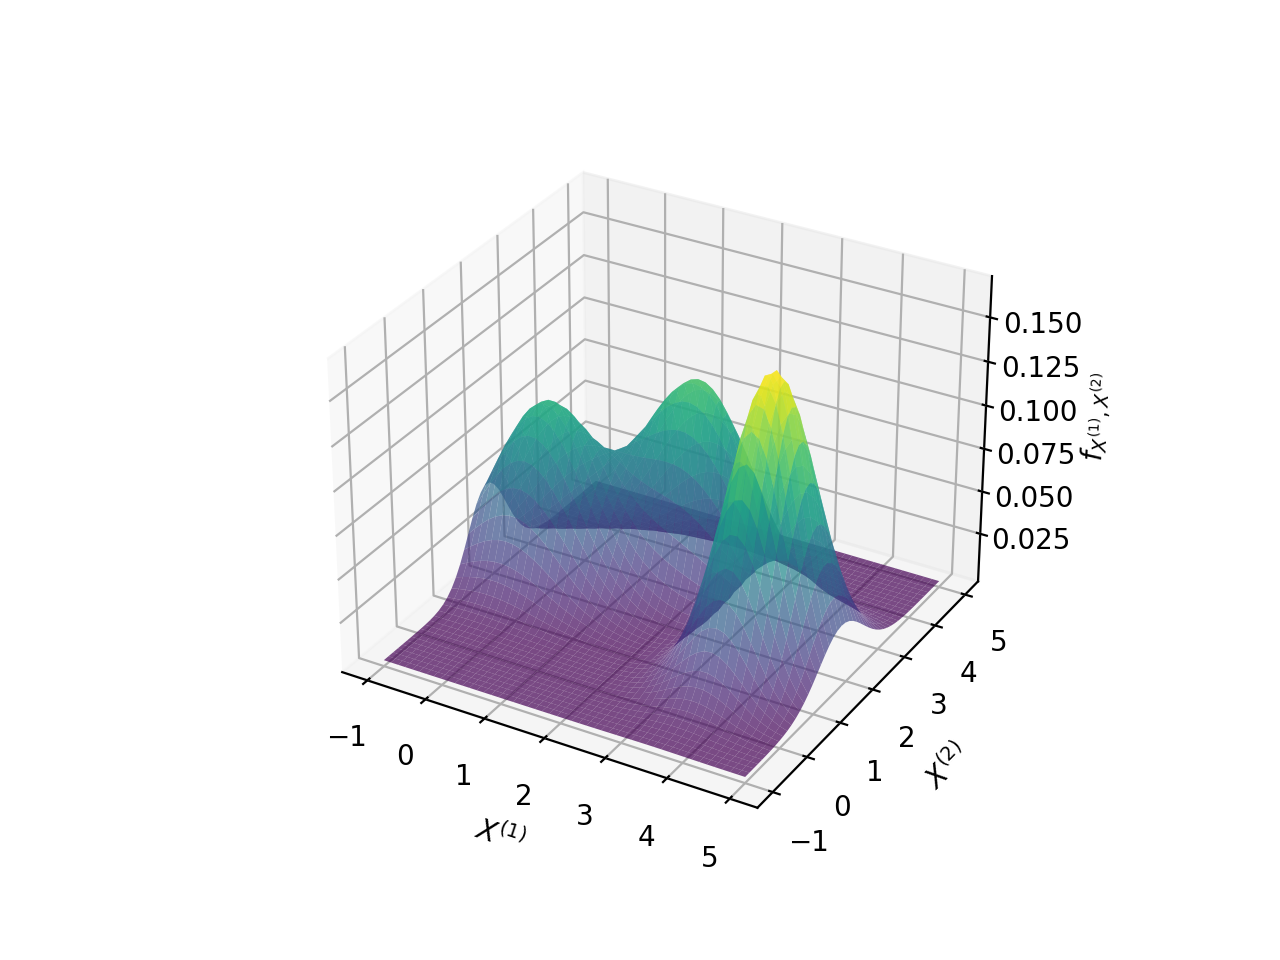

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np


def squared_mahalanobis_dist(d, metric):
    return np.sum(((d @ metric) * d), axis=-1)


def multivariate_normal_pdf(x, mean, cov):
    scale = 1 / np.sqrt(np.linalg.det(2 * np.pi * cov))
    d = x - np.expand_dims(mean, axis=0)
    metric = np.linalg.inv(cov)
    density = scale * np.exp(-0.5 * squared_mahalanobis_dist(d, metric))
    return density


def gmm(x, alphas, means, covs):
    nr_samples = x.shape[0]
    _, dim = means.shape

    density = np.zeros(nr_samples)

    for alpha, mean, cov in zip(alphas, means, covs):
        density += alpha * multivariate_normal_pdf(x, mean, cov)

    return density

# Make data.
n_points = 50
X1 = np.linspace(-1, 5, n_points)
X2 = np.linspace(-1, 5, n_points)
xx, yy = np.meshgrid(X1, X2)
grid = np.stack([xx.flatten(), yy.flatten()]).T

alphas = np.array([0.3, 0.4, 0.3])
means = np.array([[0, 2], [4, 1.5], [2, 3]])
covs = np.array([[[0.7, 0.1],
                  [0.1, 0.3]],
                 [[0.3, 0.1],
                  [0.1, 0.5]],
                 [[0.8, 0.0],
                  [0.0, 0.2]]])

joint = gmm(grid, alphas, means, covs).reshape(n_points, n_points)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=200)

surf = ax.plot_surface(xx, yy, joint, antialiased=True, alpha=0.7, cmap="viridis")
ax.set_xlabel(r"$X^{(1)}$")
ax.set_ylabel(r"$X^{(2)}$")
ax.set_zlabel(r"$f_{X^{(1)}, X^{(2)}}$")

def metropolis_hastings(density, steps):
    rand = np.random.default_rng(1337)
    sigma = 5 * 0.01
    start = np.array([[1, 1]])
    trajectory = [start]
    densities = [density(start)]

    for i in range(steps):
        old = trajectory[-1]
        proposal = old + sigma * np.random.randn(*old.shape)

        density_proposal = density(proposal)
        density_old = density(old)
        acceptance_probability = np.minimum(1, density_proposal / density_old)
        u = np.random.rand()
        if u <= acceptance_probability:
            trajectory.append(proposal)
            densities.append(density_proposal)
        else:
            trajectory.append(old)
            densities.append(density_old)

    return np.array(trajectory), np.array(densities)


def gmm_density(x):
    return gmm(x, alphas, means, covs)

    
trajectory, densities = metropolis_hastings(gmm_density, 400)

alphas = np.geomspace(0.1, 1, len(trajectory))
from ipywidgets import *

@widgets.interact(n=(1, len(trajectory), 1))
def update(n=1):

    for a, start, end, d_start, d_end in zip(alphas, trajectory[:n-1], trajectory[1:n], densities[:n-1], densities[1:n]):
        x = np.array([start[0, 0], end[0, 0]])
        y = np.array([start[0, 1], end[0, 1]])
        z = np.array([d_start[0], d_end[0]]) + 0.0001
        ax.plot(x, y, z, alpha=a, c="r", zorder=10)


plt.show()

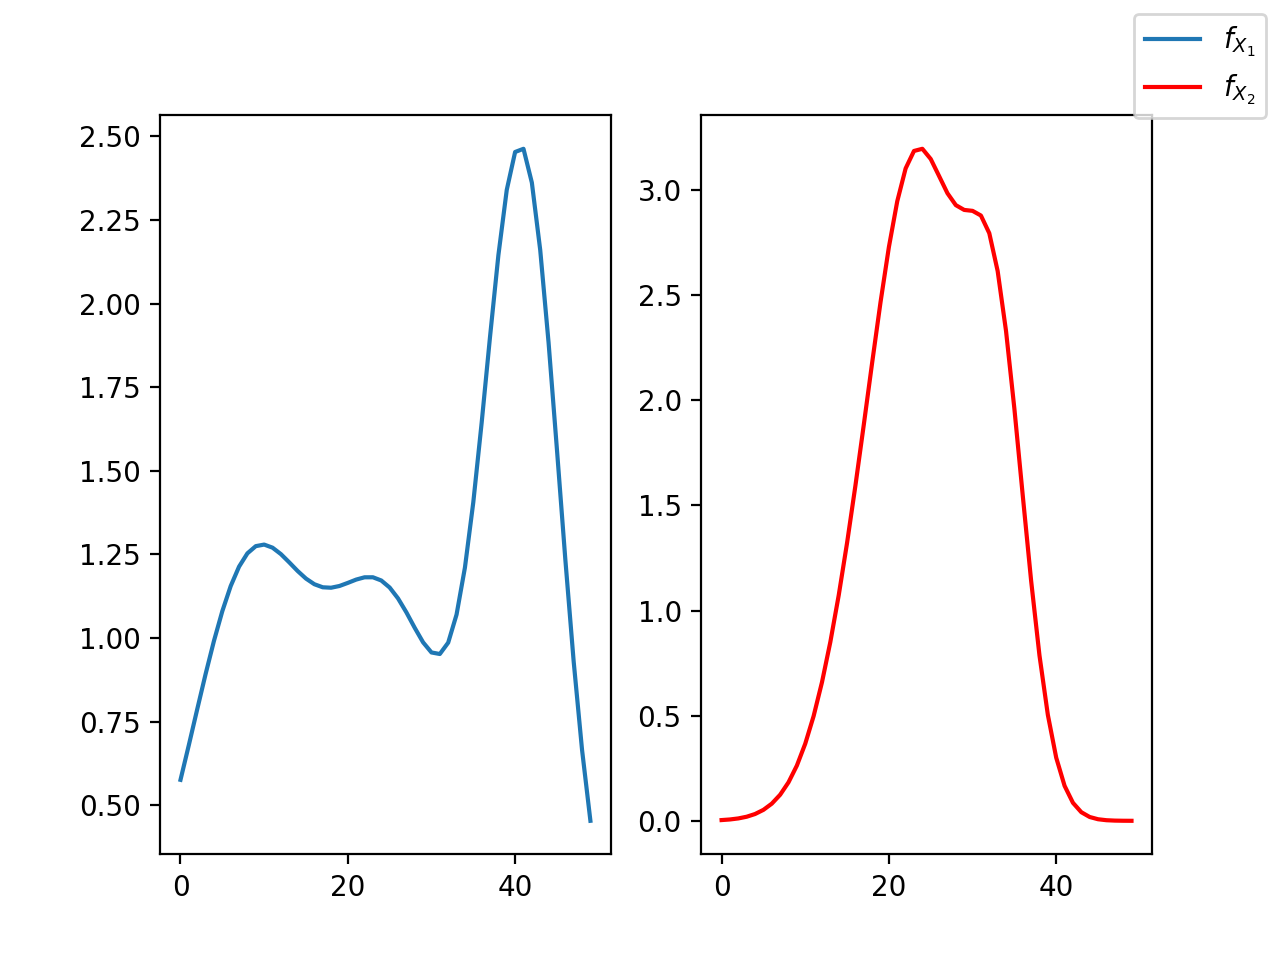

In [2]:
marginal_X1 = np.sum(joint, axis=0)
marginal_X2 = np.sum(joint, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200)
ax[0].plot(marginal_X1, label=r"$f_{X_1}$")
ax[1].plot(marginal_X2, label=r"$f_{X_2}$", c="r")

fig.legend()
plt.show()